# 'Living' Conclusion Gathering Space

## Conclusions Data Merge

-  There seems to be no pattern in the null values in target column. This indicates we can drop these rows


_County_
- we think county 12 is weird (unknown location) and introduces NA values (not included in weather data)
- maybe drop 12, but this may lead to other problems 
- county named 'unknown'
- the forums say counties 16 and 0 may be weird

_data_block_id_
- we could reduce NaN and NaT values by excluding data_block_id 1 and 0 (beginning in data set)

_Modelling / Time Series_
- We are unsure about modelling (is time series model needed? maybe ARMA?) Forums suggest e.g. XGBoost


## Conclusions EDA
- consumption has noticeable affects by winter holidays
- seems consumption is growing over time
- county 0 is dominating, Tallinn located there
- seems like temperature to production ratio changed last year
- product_type 2 attract producers with small installed capacity thus low production
- while product_type 3 attract the opposite cluster, producers with a lot of installed_capacity
- Surface solar radiation seems to have a stronger correlation with target than direct_solar
- There seems to be a 'split' around 6000 (unit?) daily mean target
- We expected more businesses in the top-producers

# Preparing Data

In [20]:
import pandas as pd
import seaborn as sns

In [21]:
client = pd.read_csv('../data/client.csv')
client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


## Client Data

In [22]:
# Datatype conversion
client.date = pd.to_datetime(client.date)
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   product_type        41919 non-null  int64         
 1   county              41919 non-null  int64         
 2   eic_count           41919 non-null  int64         
 3   installed_capacity  41919 non-null  float64       
 4   is_business         41919 non-null  int64         
 5   date                41919 non-null  datetime64[ns]
 6   data_block_id       41919 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 2.2 MB


In [23]:
# categoricals?
display(client.product_type.unique())
display(client.is_business.unique())
display(client.county.unique())

array([1, 2, 3, 0])

array([0, 1])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

<Axes: xlabel='date', ylabel='data_block_id'>

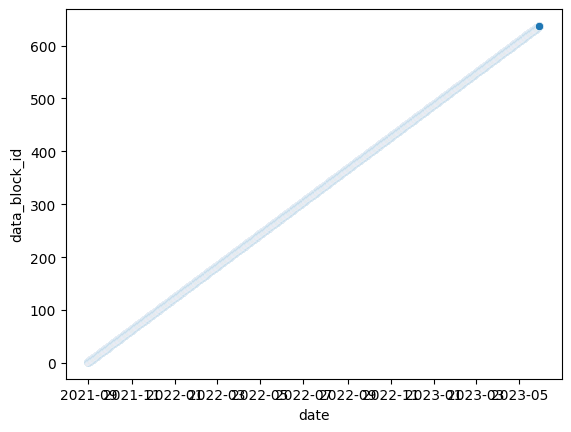

In [24]:
sns.scatterplot(x = client.date, y = client.data_block_id)

In [25]:
display(min(client.date))
display(max(client.date))
display(client.data_block_id.nunique())

Timestamp('2021-09-01 00:00:00')

Timestamp('2023-05-29 00:00:00')

636

    First day is '2021-09-01 00:00:00', last day is '2023-05-29 00:00:00'. There are 636 unique days, and data_block_id corresponds to date. 

## Electricity Prices Data

In [26]:
electricity_prices = pd.read_csv('../data/electricity_prices.csv')
electricity_prices.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [27]:
electricity_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   forecast_date  15286 non-null  object 
 1   euros_per_mwh  15286 non-null  float64
 2   origin_date    15286 non-null  object 
 3   data_block_id  15286 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 477.8+ KB


In [28]:
electricity_prices.forecast_date = pd.to_datetime(electricity_prices.forecast_date)
electricity_prices.origin_date = pd.to_datetime(electricity_prices.origin_date)

electricity_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   forecast_date  15286 non-null  datetime64[ns]
 1   euros_per_mwh  15286 non-null  float64       
 2   origin_date    15286 non-null  datetime64[ns]
 3   data_block_id  15286 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 477.8 KB


In [29]:
electricity_prices.nunique()

forecast_date    15286
euros_per_mwh    11025
origin_date      15286
data_block_id      637
dtype: int64

In [30]:
electricity_prices.forecast_date.unique()

<DatetimeArray>
['2021-09-01 00:00:00', '2021-09-01 01:00:00', '2021-09-01 02:00:00',
 '2021-09-01 03:00:00', '2021-09-01 04:00:00', '2021-09-01 05:00:00',
 '2021-09-01 06:00:00', '2021-09-01 07:00:00', '2021-09-01 08:00:00',
 '2021-09-01 09:00:00',
 ...
 '2023-05-30 14:00:00', '2023-05-30 15:00:00', '2023-05-30 16:00:00',
 '2023-05-30 17:00:00', '2023-05-30 18:00:00', '2023-05-30 19:00:00',
 '2023-05-30 20:00:00', '2023-05-30 21:00:00', '2023-05-30 22:00:00',
 '2023-05-30 23:00:00']
Length: 15286, dtype: datetime64[ns]

    Electricity price forecast are available for each hour of the day (637 days * 24 hours = 15286 unique datetimes) (for 637 days, one day more than client data; somewhere there are 2h missing)




## Forecast Weather Data

In [31]:
forecast_weather = pd.read_csv('../data/forecast_weather.csv')

forecast_weather.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0


In [32]:
forecast_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   latitude                           float64
 1   longitude                          float64
 2   origin_datetime                    object 
 3   hours_ahead                        int64  
 4   temperature                        float64
 5   dewpoint                           float64
 6   cloudcover_high                    float64
 7   cloudcover_low                     float64
 8   cloudcover_mid                     float64
 9   cloudcover_total                   float64
 10  10_metre_u_wind_component          float64
 11  10_metre_v_wind_component          float64
 12  data_block_id                      int64  
 13  forecast_datetime                  object 
 14  direct_solar_radiation             float64
 15  surface_solar_radiation_downwards  float64
 16  snowfall          

In [33]:
forecast_weather.origin_datetime = pd.to_datetime(forecast_weather.origin_datetime)
forecast_weather.forecast_datetime = pd.to_datetime(forecast_weather.forecast_datetime)

forecast_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Dtype              
---  ------                             -----              
 0   latitude                           float64            
 1   longitude                          float64            
 2   origin_datetime                    datetime64[ns, UTC]
 3   hours_ahead                        int64              
 4   temperature                        float64            
 5   dewpoint                           float64            
 6   cloudcover_high                    float64            
 7   cloudcover_low                     float64            
 8   cloudcover_mid                     float64            
 9   cloudcover_total                   float64            
 10  10_metre_u_wind_component          float64            
 11  10_metre_v_wind_component          float64            
 12  data_block_id                      int64  

In [34]:
forecast_weather.nunique()

latitude                                   8
longitude                                 14
origin_datetime                          637
hours_ahead                               48
temperature                           400895
dewpoint                              439461
cloudcover_high                       212178
cloudcover_low                        408609
cloudcover_mid                        308004
cloudcover_total                      698385
10_metre_u_wind_component            3166997
10_metre_v_wind_component            3142161
data_block_id                            637
forecast_datetime                      15312
direct_solar_radiation               1199360
surface_solar_radiation_downwards    1496773
snowfall                              256201
total_precipitation                   540661
dtype: int64

In [35]:
forecast_weather.groupby(['latitude', 'longitude']).nunique()

origin_datetime  hours_ahead  temperature  dewpoint   
latitude longitude                                                        
57.6     21.7                   637           48        27706     28047  \
         22.2                   637           48        28285     28292   
         22.7                   637           48        27799     28120   
         23.2                   637           48        27587     28120   
         23.7                   637           48        27697     28045   
...                             ...          ...          ...       ...   
59.7     26.2                   637           48        27959     28170   
         26.7                   637           48        28019     28199   
         27.2                   637           48        28033     28129   
         27.7                   637           48        28156     28283   
         28.2                   637           48        28495     28373   

                    cloudcover_high  cloudcover_low  cloudcover_mid   
latitude longitude                                                    
57.6     21.7                 10902           14794           13125  \
         22.2                 11118           15006           13505   
         22.7                 11000           14869           13640   
         23.2                 10821           14289           13280   
         23.7                 11010           14380           13396   
...                             ...             ...             ...   
59.7     26.2                 11356           14511           13565   
         26.7                 11082           14412           13420   
         27.2                 11387           14400           13519   
         27.7                 10929           14201           13348   
         28.2                 11102           14822           13779   

                    cloudcover_total  10_metre_u_wind_component   
latitude longitude                                                
57.6     21.7                  16896                      30563  \
         22.2                  17130                      30548   
         22.7                  17178                      30554   
         23.2                  16737                      30558   
         23.7                  16817                      30561   
...                              ...                        ...   
59.7     26.2                  16080                      30561   
         26.7                  15878                      30563   
         27.2                  15858                      30551   
         27.7                  15712                      30555   
         28.2                  16164                      30542   

                    10_metre_v_wind_component  data_block_id   
latitude longitude                                             
57.6     21.7                           30551            637  \
         22.2                           30550            637   
         22.7                           30556            637   
         23.2                           30556            637   
         23.7                           30560            637   
...                                       ...            ...   
59.7     26.2                           30559            637   
         26.7                           30560            637   
         27.2                           30563            637   
         27.7                           30556            637   
         28.2                           30553            637   

                    forecast_datetime  direct_solar_radiation   
latitude longitude                                              
57.6     21.7                   15312                   14747  \
         22.2                   15312                   14555   
         22.7                   15312                   14561   
         23.2                   15312                   14670   
         23.7            

    There are 112 unique combinations of lat and long (unique weather stations). 
    So for each forecast_date, there are 112 observations (one from each station). 


In [36]:
display(forecast_weather.hours_ahead.nunique())
display(forecast_weather.origin_datetime.nunique())
display(forecast_weather.groupby('origin_datetime').forecast_datetime.size()/112)

48

637

origin_datetime
2021-09-01 00:00:00+00:00    48.0
2021-09-02 00:00:00+00:00    48.0
2021-09-03 00:00:00+00:00    48.0
2021-09-04 00:00:00+00:00    48.0
2021-09-05 00:00:00+00:00    48.0
                             ... 
2023-05-26 00:00:00+00:00    48.0
2023-05-27 00:00:00+00:00    48.0
2023-05-28 00:00:00+00:00    48.0
2023-05-29 00:00:00+00:00    48.0
2023-05-30 00:00:00+00:00    48.0
Name: forecast_datetime, Length: 637, dtype: float64

In [37]:
forecast_weather.groupby(['origin_datetime', 'forecast_datetime']).count()

latitude  longitude   
origin_datetime           forecast_datetime                                
2021-09-01 00:00:00+00:00 2021-09-01 01:00:00+00:00       112        112  \
                          2021-09-01 02:00:00+00:00       112        112   
                          2021-09-01 03:00:00+00:00       112        112   
                          2021-09-01 04:00:00+00:00       112        112   
                          2021-09-01 05:00:00+00:00       112        112   
...                                                       ...        ...   
2023-05-30 00:00:00+00:00 2023-05-31 20:00:00+00:00       112        112   
                          2023-05-31 21:00:00+00:00       112        112   
                          2023-05-31 22:00:00+00:00       112        112   
                          2023-05-31 23:00:00+00:00       112        112   
                          2023-06-01 00:00:00+00:00       112        112   

                                                     hours_ahead  temperature   
origin_datetime           forecast_datetime                                     
2021-09-01 00:00:00+00:00 2021-09-01 01:00:00+00:00          112          112  \
                          2021-09-01 02:00:00+00:00          112          112   
                          2021-09-01 03:00:00+00:00          112          112   
                          2021-09-01 04:00:00+00:00          112          112   
                          2021-09-01 05:00:00+00:00          112          112   
...                                                          ...          ...   
2023-05-30 00:00:00+00:00 2023-05-31 20:00:00+00:00          112          112   
                          2023-05-31 21:00:00+00:00          112          112   
                          2023-05-31 22:00:00+00:00          112          112   
                          2023-05-31 23:00:00+00:00          112          112   
                          2023-06-01 00:00:00+00:00          112          112   

                                                     dewpoint   
origin_datetime           forecast_datetime                     
2021-09-01 00:00:00+00:00 2021-09-01 01:00:00+00:00       112  \
                          2021-09-01 02:00:00+00:00       112   
                          2021-09-01 03:00:00+00:00       112   
                          2021-09-01 04:00:00+00:00       112   
                          2021-09-01 05:00:00+00:00       112   
...                                                       ...   
2023-05-30 00:00:00+00:00 2023-05-31 20:00:00+00:00       112   
                          2023-05-31 21:00:00+00:00       112   
                          2023-05-31 22:00:00+00:00       112   
                          2023-05-31 23:00:00+00:00       112   
                          2023-06-01 00:00:00+00:00       112   

                                                     cloudcover_high   
origin_datetime           forecast_datetime                            
2021-09-01 00:00:00+00:00 2021-09-01 01:00:00+00:00              112  \
                          2021-09-01 02:00:00+00:00              112   
                          2021-09-01 03:00:00+00:00              112   
                          2021-09-01 04:00:00+00:00              112   
                          2021-09-01 05:00:00+00:00              112   
...                                                              ...   
2023-05-30 00:00:00+00:00 2023-05-31 20:00:00+00:00              112   
                          2023-05-31 21:00:00+00:00              112   
                          2023-05-31 22:00:00+00:00              112   
                          2023-05-31 23:00:00+00:00              112   
                          2023-06-01 00:00:00+00:00              112   

                                                     cloudcover_low   
origin_datetime           forecast_datetime                           
2021-09-01 00:00:00+00:00 2021-09-01 01:00:00+00:00             112  \
              

## Gas Prices Data

In [38]:
gas_prices = pd.read_csv('../data/gas_prices.csv')

gas_prices.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [39]:
gas_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   forecast_date          637 non-null    object 
 1   lowest_price_per_mwh   637 non-null    float64
 2   highest_price_per_mwh  637 non-null    float64
 3   origin_date            637 non-null    object 
 4   data_block_id          637 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 25.0+ KB


In [40]:
gas_prices.forecast_date = pd.to_datetime(gas_prices.forecast_date)
gas_prices.origin_date = pd.to_datetime(gas_prices.origin_date)

gas_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   forecast_date          637 non-null    datetime64[ns]
 1   lowest_price_per_mwh   637 non-null    float64       
 2   highest_price_per_mwh  637 non-null    float64       
 3   origin_date            637 non-null    datetime64[ns]
 4   data_block_id          637 non-null    int64         
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 25.0 KB


In [41]:
gas_prices.describe()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
count,637,637.000000,637.000000,637,637.000000
mean,2022-07-16 00:00:00,95.036750,107.754631,2022-07-15 00:00:00,319.000000
min,2021-09-01 00:00:00,28.100000,34.000000,2021-08-31 00:00:00,1.000000
25%,2022-02-07 00:00:00,60.000000,67.530000,2022-02-06 00:00:00,160.000000
50%,2022-07-16 00:00:00,85.210000,93.470000,2022-07-15 00:00:00,319.000000
75%,2022-12-22 00:00:00,109.000000,130.740000,2022-12-21 00:00:00,478.000000
max,2023-05-30 00:00:00,250.000000,305.000000,2023-05-29 00:00:00,637.000000
std,NaN,47.552295,54.743666,NaN,184.030342


## Historical Weather Data

In [42]:
historical_weather = pd.read_csv('../data/historical_weather.csv')

historical_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1


In [43]:
historical_weather.datetime = pd.to_datetime(historical_weather.datetime)

historical_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710800 entries, 0 to 1710799
Data columns (total 18 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   datetime                datetime64[ns]
 1   temperature             float64       
 2   dewpoint                float64       
 3   rain                    float64       
 4   snowfall                float64       
 5   surface_pressure        float64       
 6   cloudcover_total        int64         
 7   cloudcover_low          int64         
 8   cloudcover_mid          int64         
 9   cloudcover_high         int64         
 10  windspeed_10m           float64       
 11  winddirection_10m       int64         
 12  shortwave_radiation     float64       
 13  direct_solar_radiation  float64       
 14  diffuse_radiation       float64       
 15  latitude                float64       
 16  longitude               float64       
 17  data_block_id           int64         
dtypes:

In [44]:
historical_weather.isnull().sum()

datetime                  0
temperature               0
dewpoint                  0
rain                      0
snowfall                  0
surface_pressure          0
cloudcover_total          0
cloudcover_low            0
cloudcover_mid            0
cloudcover_high           0
windspeed_10m             0
winddirection_10m         0
shortwave_radiation       0
direct_solar_radiation    0
diffuse_radiation         0
latitude                  0
longitude                 0
data_block_id             0
dtype: int64

## Train Data & Checking for NULL values

In [45]:
train = pd.read_csv('../data/train.csv')

train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [46]:
train.datetime = pd.to_datetime(train.datetime, format='%Y-%m-%d %H:%M:%S')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   county              int64         
 1   is_business         int64         
 2   product_type        int64         
 3   target              float64       
 4   is_consumption      int64         
 5   datetime            datetime64[ns]
 6   data_block_id       int64         
 7   row_id              int64         
 8   prediction_unit_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 138.6 MB


In [47]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01,0,0,0
1,0,0,1,96.590,1,2021-09-01,0,1,0
2,0,0,2,0.000,0,2021-09-01,0,2,1
3,0,0,2,17.314,1,2021-09-01,0,3,1
4,0,0,3,2.904,0,2021-09-01,0,4,2


In [48]:
train.datetime[1000]

Timestamp('2021-09-01 08:00:00')

In [49]:
train.isnull().sum()

county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

In [50]:
train.groupby('is_consumption').agg({'target': lambda x: x.isnull().sum()})

,target
is_consumption,
0,264
1,264


In [51]:
train[train.target.isnull()]

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
178938,0,0,1,NaN,0,2021-10-31 03:00:00,60,178938,0
178939,0,0,1,NaN,1,2021-10-31 03:00:00,60,178939,0
178940,0,0,2,NaN,0,2021-10-31 03:00:00,60,178940,1
178941,0,0,2,NaN,1,2021-10-31 03:00:00,60,178941,1
178942,0,0,3,NaN,0,2021-10-31 03:00:00,60,178942,2
...,...,...,...,...,...,...,...,...,...
1806379,15,1,0,NaN,1,2023-03-26 03:00:00,571,1806379,64
1806380,15,1,1,NaN,0,2023-03-26 03:00:00,571,1806380,59
1806381,15,1,1,NaN,1,2023-03-26 03:00:00,571,1806381,59
1806382,15,1,3,NaN,0,2023-03-26 03:00:00,571,1806382,60


    There seems to be no pattern in the null values in target column. This indicates we can drop these rows

In [52]:
weather_station_to_county_mapping = pd.read_csv('../data/weather_station_to_county_mapping.csv')

weather_station_to_county_mapping.head()

,county_name,longitude,latitude,county
0,NaN,21.7,57.6,NaN
1,NaN,21.7,57.9,NaN
2,NaN,21.7,58.2,NaN
3,NaN,21.7,58.5,NaN
4,NaN,21.7,58.8,NaN


In [53]:
weather_station_to_county_mapping.county.unique()

array([nan, 10.,  1.,  7.,  6.,  9.,  0., 14.,  3., 13., 11.,  4.,  5.,
       15.,  8.,  2.])

In [54]:
weather_station_to_county_mapping.county_name.unique()

array([nan, 'Saaremaa', 'Hiiumaa', 'Pärnumaa', 'Läänemaa', 'Raplamaa',
       'Harjumaa', 'Viljandimaa', 'Järvamaa', 'Valgamaa', 'Tartumaa',
       'Jõgevamaa', 'Lääne-Virumaa', 'Võrumaa', 'Põlvamaa', 'Ida-Virumaa'],
      dtype=object)

https://www.kaggle.com/code/fabiendaniel/mapping-locations-and-county-codes/notebook  for county codes
Here, they remove the 'maa' appendix from the county names. but is this really needed?

## Data Merging (now we merge everything to train)

In [55]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01,0,0,0
1,0,0,1,96.590,1,2021-09-01,0,1,0
2,0,0,2,0.000,0,2021-09-01,0,2,1
3,0,0,2,17.314,1,2021-09-01,0,3,1
4,0,0,3,2.904,0,2021-09-01,0,4,2


### Merge Client

In [56]:
client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [57]:
print(client.size, train.size)

293433 18165168


In [58]:
# append '_client' to merged columns
client.columns = [f"{column}_client" if column not in ['data_block_id', 'county', 'is_business', 'product_type'] else column for column in client.columns]

In [59]:
# merge train and client

merged_df = pd.merge(train, client, on=['data_block_id', 'county', 'is_business', 'product_type'], how='left')

merged_df.head()


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,eic_count_client,installed_capacity_client,date_client
0,0,0,1,0.713,0,2021-09-01,0,0,0,NaN,NaN,NaT
1,0,0,1,96.590,1,2021-09-01,0,1,0,NaN,NaN,NaT
2,0,0,2,0.000,0,2021-09-01,0,2,1,NaN,NaN,NaT
3,0,0,2,17.314,1,2021-09-01,0,3,1,NaN,NaN,NaT
4,0,0,3,2.904,0,2021-09-01,0,4,2,NaN,NaN,NaT


there are a few/a lot null values, especially at the beginning and end of period


In [60]:
# how many eic counts per data_block_id?
merged_df[merged_df.eic_count_client.isnull()].data_block_id.value_counts()

data_block_id
0      2928
1      2928
30      144
31      144
122     144
123     144
154      96
607      96
153      96
584      48
540      48
533      48
541      48
572      48
573      48
580      48
583      48
596      48
590      48
591      48
595      48
519      48
602      48
603      48
606      48
608      48
611      48
532      48
458      48
518      48
514      48
91       48
92       48
172      48
173      48
203      48
204      48
215      48
216      48
273      48
274      48
365      48
366      48
395      48
396      48
426      48
427      48
513      48
612      48
Name: count, dtype: int64

In [61]:
# do dates in train and client overlap? 
print(set(client.date_client.dt.date) ^ set(train.datetime.dt.date))
print(set(train.data_block_id) ^ set(client.data_block_id))

{datetime.date(2023, 5, 30), datetime.date(2023, 5, 31)}
{0, 1}


In [62]:
def print_block(dbid):
    display("TRAIN", train[train['data_block_id'] == dbid])
#     display("FORC WEATHER", forecast_weather[forecast_weather['data_block_id'] == dbid])
    display("CLIENT", client[client['data_block_id'] == dbid])
#     display("HIST WEATHER", historical_weather[historical_weather['data_block_id'] == dbid])
#     display("E PRICES", electricity_prices[electricity_prices['data_block_id'] == dbid])
#     display("G PRICES", gas_prices[gas_prices['data_block_id'] == dbid])

print_block(10)

'TRAIN'

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
29280,0,0,1,0.000,0,2021-09-11 00:00:00,10,29280,0
29281,0,0,1,109.095,1,2021-09-11 00:00:00,10,29281,0
29282,0,0,2,0.000,0,2021-09-11 00:00:00,10,29282,1
29283,0,0,2,17.503,1,2021-09-11 00:00:00,10,29283,1
29284,0,0,3,0.077,0,2021-09-11 00:00:00,10,29284,2
...,...,...,...,...,...,...,...,...,...
32203,15,0,3,76.522,1,2021-09-11 23:00:00,10,32203,58
32204,15,1,1,0.100,0,2021-09-11 23:00:00,10,32204,59
32205,15,1,1,17.543,1,2021-09-11 23:00:00,10,32205,59
32206,15,1,3,0.000,0,2021-09-11 23:00:00,10,32206,60


'CLIENT'

,product_type,county,eic_count_client,installed_capacity_client,is_business,date_client,data_block_id
488,1,0,108,952.89,0,2021-09-09,10
489,2,0,17,166.40,0,2021-09-09,10
490,3,0,687,7199.88,0,2021-09-09,10
491,0,0,5,400.00,1,2021-09-09,10
492,1,0,43,1411.00,1,2021-09-09,10
...,...,...,...,...,...,...,...
544,3,14,67,3114.60,1,2021-09-09,10
545,1,15,10,83.20,0,2021-09-09,10
546,3,15,61,918.20,0,2021-09-09,10
547,1,15,7,325.00,1,2021-09-09,10


There is a problem with NULL values after merging. one source are the start and end dates, but we don't know whats happening in between and whether this is problematic.
Maybe some client data is sporadically missing?

### Merge Gas Prices

In [63]:
gas_prices.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [64]:
# append _gas_prices to columns
gas_prices.columns = [f"{column}_gas_prices" if column != 'data_block_id' else column for column in gas_prices.columns]

In [65]:
# merge gas_prices

merged_df = pd.merge(merged_df, gas_prices, on=['data_block_id'], how='left')

merged_df.tail()


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,eic_count_client,installed_capacity_client,date_client,forecast_date_gas_prices,lowest_price_per_mwh_gas_prices,highest_price_per_mwh_gas_prices,origin_date_gas_prices
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,15.0,620.0,2023-05-29,2023-05-30,29.0,34.0,2023-05-29
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,20.0,624.5,2023-05-29,2023-05-30,29.0,34.0,2023-05-29
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,20.0,624.5,2023-05-29,2023-05-30,29.0,34.0,2023-05-29
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,55.0,2188.2,2023-05-29,2023-05-30,29.0,34.0,2023-05-29
2018351,15,1,3,196.240,1,2023-05-31 23:00:00,637,2018351,60,55.0,2188.2,2023-05-29,2023-05-30,29.0,34.0,2023-05-29


### Merge Electricity Prices

In [66]:
# add time column for merging with electricity data
merged_df['time_of_day'] = merged_df['datetime'].dt.time
merged_df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,eic_count_client,installed_capacity_client,date_client,forecast_date_gas_prices,lowest_price_per_mwh_gas_prices,highest_price_per_mwh_gas_prices,origin_date_gas_prices,time_of_day
0,0,0,1,0.713,0,2021-09-01,0,0,0,NaN,NaN,NaT,NaT,NaN,NaN,NaT,00:00:00
1,0,0,1,96.590,1,2021-09-01,0,1,0,NaN,NaN,NaT,NaT,NaN,NaN,NaT,00:00:00
2,0,0,2,0.000,0,2021-09-01,0,2,1,NaN,NaN,NaT,NaT,NaN,NaN,NaT,00:00:00
3,0,0,2,17.314,1,2021-09-01,0,3,1,NaN,NaN,NaT,NaT,NaN,NaN,NaT,00:00:00
4,0,0,3,2.904,0,2021-09-01,0,4,2,NaN,NaN,NaT,NaT,NaN,NaN,NaT,00:00:00


In [67]:
# Merge electricity prices
# the prices are available hourly -> create new column with time 

electricity_prices['time_of_day'] = electricity_prices.forecast_date.dt.time

# append electricity_prices to column names
electricity_prices.columns = [f"{column}_electricity_prices" if column not in ['time_of_day','data_block_id'] else column for column in electricity_prices.columns]



### Merge Electricity Prices

In [68]:
# merge electricity_prices

merged_df = pd.merge(merged_df, electricity_prices, on = ['data_block_id', 'time_of_day'], how='left')

merged_df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,eic_count_client,installed_capacity_client,date_client,forecast_date_gas_prices,lowest_price_per_mwh_gas_prices,highest_price_per_mwh_gas_prices,origin_date_gas_prices,time_of_day,forecast_date_electricity_prices,euros_per_mwh_electricity_prices,origin_date_electricity_prices
0,0,0,1,0.713,0,2021-09-01,0,0,0,NaN,NaN,NaT,NaT,NaN,NaN,NaT,00:00:00,NaT,NaN,NaT
1,0,0,1,96.590,1,2021-09-01,0,1,0,NaN,NaN,NaT,NaT,NaN,NaN,NaT,00:00:00,NaT,NaN,NaT
2,0,0,2,0.000,0,2021-09-01,0,2,1,NaN,NaN,NaT,NaT,NaN,NaN,NaT,00:00:00,NaT,NaN,NaT
3,0,0,2,17.314,1,2021-09-01,0,3,1,NaN,NaN,NaT,NaT,NaN,NaN,NaT,00:00:00,NaT,NaN,NaT
4,0,0,3,2.904,0,2021-09-01,0,4,2,NaN,NaN,NaT,NaT,NaN,NaN,NaT,00:00:00,NaT,NaN,NaT


### Merge Historical Weather

In [69]:
# historic weather

historical_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1
1,2021-09-01,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1
2,2021-09-01,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1
3,2021-09-01,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1
4,2021-09-01,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1


In [70]:
# get county and county_name from weather_station_to_county_mapping (merge on latitude and longitude)

# round lat and long to avoid mismatching due to different accuracy
historical_weather.latitude = historical_weather.latitude.round(1)
historical_weather.longitude = historical_weather.longitude.round(1)

weather_station_to_county_mapping.latitude = weather_station_to_county_mapping.latitude.round(1)
weather_station_to_county_mapping.longitude = weather_station_to_county_mapping.longitude.round(1)


In [71]:
# merge historical weather to get counties
merged_hist_weather = pd.merge(historical_weather, weather_station_to_county_mapping, on=['latitude', 'longitude'], how='left')
# get time of day
merged_hist_weather['time_of_day'] = merged_hist_weather['datetime'].dt.time

# aggregate by county and time (summarize weather stations for same county)
merged_hist_weather = merged_hist_weather.groupby(['county', 'time_of_day', 'datetime', 'data_block_id']).mean(numeric_only=True).reset_index()

# append _hist_weather to column names
merged_hist_weather.columns = [f"{column}_hist_weather" if column not in ['county', 'time_of_day','data_block_id'] else column for column in merged_hist_weather.columns]


merged_hist_weather.sample()


,county,time_of_day,datetime_hist_weather,data_block_id,temperature_hist_weather,dewpoint_hist_weather,rain_hist_weather,snowfall_hist_weather,surface_pressure_hist_weather,cloudcover_total_hist_weather,cloudcover_low_hist_weather,cloudcover_mid_hist_weather,cloudcover_high_hist_weather,windspeed_10m_hist_weather,winddirection_10m_hist_weather,shortwave_radiation_hist_weather,direct_solar_radiation_hist_weather,diffuse_radiation_hist_weather,latitude_hist_weather,longitude_hist_weather
61985,4.0,01:00:00,2022-05-07 01:00:00,249,6.733333,3.8,0.0,0.0,1009.233333,6.0,4.666667,3.333333,0.0,2.333333,220.0,0.0,0.0,0.0,58.7,26.366667


In [72]:
# merge to merged_df
merged_df = pd.merge(merged_df, merged_hist_weather, on=['data_block_id', 'time_of_day', 'county'], how='left')

### Merge Forecast Weather

In [73]:
forecast_weather.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0


In [74]:
# forecast weather

#round lat and long
forecast_weather.latitude = forecast_weather.latitude.round(1)
forecast_weather.longitude = forecast_weather.longitude.round(1)

# merge to get counties
merged_forecast_weather = pd.merge(forecast_weather, weather_station_to_county_mapping, on=['latitude', 'longitude'], how='left')
# merged_forecast_weather['time_of_day'] = merged_forecast_weather.

# # aggregate for duplicate locations
merged_forecast_weather = merged_forecast_weather.groupby(['county', 'forecast_datetime', 'data_block_id']).mean(numeric_only=True).reset_index()

# append forecast_weather to column names
merged_forecast_weather.columns = [f"{column}_forecast_weather" if column not in ['county', 'forecast_datetime','data_block_id'] else column for column in merged_forecast_weather.columns]


merged_forecast_weather.sample()

,county,forecast_datetime,data_block_id,latitude_forecast_weather,longitude_forecast_weather,hours_ahead_forecast_weather,temperature_forecast_weather,dewpoint_forecast_weather,cloudcover_high_forecast_weather,cloudcover_low_forecast_weather,cloudcover_mid_forecast_weather,cloudcover_total_forecast_weather,10_metre_u_wind_component_forecast_weather,10_metre_v_wind_component_forecast_weather,direct_solar_radiation_forecast_weather,surface_solar_radiation_downwards_forecast_weather,snowfall_forecast_weather,total_precipitation_forecast_weather
2579,0.0,2021-10-25 06:00:00+00:00,55,59.3,24.866667,6.0,7.893884,5.245447,0.999435,0.114319,0.420105,0.999703,5.338038,4.229786,0.941296,3.357576,0.0,0.0


In [75]:
merged_df.datetime.dt.tz_localize('EET', ambiguous=True, nonexistent='shift_forward')[80000]

Timestamp('2021-09-28 07:00:00+0300', tz='EET')

In [76]:
merged_df.datetime.dt.tz_localize('EET', ambiguous=True, nonexistent='shift_forward')[1500000]

Timestamp('2022-12-20 07:00:00+0200', tz='EET')

In [77]:
merged_forecast_weather.forecast_datetime.dt.tz_convert('EET')[6000]

Timestamp('2022-01-04 15:00:00+0200', tz='EET')

In [78]:
# add EET timezone to datetime, and handle daylight-savings
merged_df['datetime_localized'] = merged_df.datetime.dt.tz_localize('EET', ambiguous=True, nonexistent='shift_forward')

# convert UTC timezone to EET timezone in forecast weather
merged_forecast_weather['datetime_EET']  = merged_forecast_weather.forecast_datetime.dt.tz_convert('EET')


In [79]:
merged_forecast_weather.query('data_block_id == 300')

,county,forecast_datetime,data_block_id,latitude_forecast_weather,longitude_forecast_weather,hours_ahead_forecast_weather,temperature_forecast_weather,dewpoint_forecast_weather,cloudcover_high_forecast_weather,cloudcover_low_forecast_weather,cloudcover_mid_forecast_weather,cloudcover_total_forecast_weather,10_metre_u_wind_component_forecast_weather,10_metre_v_wind_component_forecast_weather,direct_solar_radiation_forecast_weather,surface_solar_radiation_downwards_forecast_weather,snowfall_forecast_weather,total_precipitation_forecast_weather,datetime_EET
14329,0.0,2022-06-27 01:00:00+00:00,300,59.30,24.866667,1.0,17.726831,15.787215,0.000000,0.003357,0.008809,0.009867,-1.264754,1.363535,0.000000,0.000000,0.0,0.000000,2022-06-27 04:00:00+03:00
14331,0.0,2022-06-27 02:00:00+00:00,300,59.30,24.866667,2.0,17.934391,16.112492,0.000000,0.003840,0.001831,0.005351,-1.073307,1.067064,76.571599,9.877279,0.0,0.000000,2022-06-27 05:00:00+03:00
14333,0.0,2022-06-27 03:00:00+00:00,300,59.30,24.866667,3.0,19.487288,16.575301,0.000000,0.000000,0.000244,0.000244,-1.185901,1.050166,289.486844,68.890875,0.0,0.000000,2022-06-27 06:00:00+03:00
14335,0.0,2022-06-27 04:00:00+00:00,300,59.30,24.866667,4.0,21.966781,17.163924,0.000000,0.000262,0.000280,0.000539,-1.105384,0.556716,488.340764,166.954867,0.0,0.000000,2022-06-27 07:00:00+03:00
14337,0.0,2022-06-27 05:00:00+00:00,300,59.30,24.866667,5.0,24.450098,17.612248,0.000000,0.008311,0.000163,0.008382,-1.017414,0.301280,621.634103,286.280498,0.0,0.000000,2022-06-27 08:00:00+03:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442478,15.0,2022-06-28 20:00:00+00:00,300,57.78,27.100000,44.0,22.470117,19.469775,0.528113,0.015137,0.058371,0.556158,-1.712890,0.529172,2.514667,0.056000,0.0,0.000000,2022-06-28 23:00:00+03:00
442480,15.0,2022-06-28 21:00:00+00:00,300,57.78,27.100000,45.0,21.575977,19.339404,0.370251,0.031049,0.076743,0.419739,-1.573499,0.936665,0.000000,0.000000,0.0,0.000000,2022-06-29 00:00:00+03:00
442482,15.0,2022-06-28 22:00:00+00:00,300,57.78,27.100000,46.0,20.878320,19.020068,0.509418,0.072824,0.216644,0.618463,-1.143979,0.731405,0.000000,0.000000,0.0,0.000464,2022-06-29 01:00:00+03:00
442484,15.0,2022-06-28 23:00:00+00:00,300,57.78,27.100000,47.0,20.642871,18.551855,0.942194,0.114362,0.345221,0.961719,-1.657865,-0.578932,0.000000,0.000000,0.0,0.001295,2022-06-29 02:00:00+03:00


In [80]:
# merge forecast_weather
merged_df = pd.merge(merged_df, merged_forecast_weather, left_on=['data_block_id', 'datetime_localized', 'county'], right_on=['data_block_id', 'datetime_EET', 'county'], how='left')

merged_df.sample(10)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,eic_count_client,...,cloudcover_low_forecast_weather,cloudcover_mid_forecast_weather,cloudcover_total_forecast_weather,10_metre_u_wind_component_forecast_weather,10_metre_v_wind_component_forecast_weather,direct_solar_radiation_forecast_weather,surface_solar_radiation_downwards_forecast_weather,snowfall_forecast_weather,total_precipitation_forecast_weather,datetime_EET
1222229,13,1,1,25.745,1,2022-09-26 06:00:00,390,1222229,63,8.0,...,1.000000,0.048645,1.000004,-0.655814,0.316720,0.000000,0.000000,0.000000,0.000000e+00,2022-09-26 06:00:00+03:00
1170424,3,1,1,0.000,0,2022-09-10 04:00:00,374,1170424,13,10.0,...,0.000000,0.000000,0.000000,-2.219164,1.387786,0.000000,0.000000,0.000000,0.000000e+00,2022-09-10 04:00:00+03:00
1176893,7,1,3,387.634,1,2022-09-12 04:00:00,376,1176893,30,60.0,...,0.072675,0.000000,0.310095,-2.122145,-1.620469,0.000000,0.000000,0.000000,0.000000e+00,2022-09-12 04:00:00+03:00
1500430,11,0,3,21.863,0,2022-12-20 10:00:00,475,1500430,45,516.0,...,0.095032,0.997988,0.999978,0.290681,3.332631,9.751111,9.212726,0.000011,1.201034e-05,2022-12-20 10:00:00+02:00
88776,7,0,1,0.006,0,2021-10-01 07:00:00,30,88776,25,31.0,...,0.768610,0.999475,0.999750,-1.733068,3.753707,0.000000,0.000000,0.000000,4.905462e-05,2021-10-01 07:00:00+03:00
366012,11,0,3,0.000,0,2021-12-31 23:00:00,121,366012,45,270.0,...,0.650540,0.213402,0.670768,1.726140,0.816358,0.000000,0.000000,0.000000,7.217750e-09,2021-12-31 23:00:00+02:00
1482430,5,1,3,0.327,0,2022-12-14 20:00:00,469,1482430,23,94.0,...,0.999657,0.984848,1.000002,1.024350,3.851189,0.000000,0.000000,0.000063,6.556511e-05,2022-12-14 20:00:00+02:00
385845,4,0,1,20.848,1,2022-01-07 08:00:00,128,385845,15,13.0,...,0.363586,0.598531,0.669698,4.621664,-1.810547,0.000000,0.000000,0.000003,3.337860e-06,2022-01-07 08:00:00+02:00
25282,3,1,3,98.816,0,2021-09-09 15:00:00,8,25282,14,38.0,...,0.782013,0.000000,0.782208,5.267238,3.217087,128.446852,246.372315,0.000000,4.545848e-05,2021-09-09 15:00:00+03:00
1876732,1,1,3,227.276,0,2023-04-17 13:00:00,593,1876732,8,17.0,...,0.008392,0.000000,0.008392,-3.541132,-2.785492,813.459080,630.866111,0.000000,0.000000e+00,2023-04-17 13:00:00+03:00


In [81]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 55 columns):
 #   Column                                              Dtype              
---  ------                                              -----              
 0   county                                              int64              
 1   is_business                                         int64              
 2   product_type                                        int64              
 3   target                                              float64            
 4   is_consumption                                      int64              
 5   datetime                                            datetime64[ns]     
 6   data_block_id                                       int64              
 7   row_id                                              int64              
 8   prediction_unit_id                                  int64              
 9   eic_count_client                   

In [82]:
merged_df.size

111009360

## Checking for NULL values on merged data

In [83]:
merged_df.isnull().sum()

county                                                    0
is_business                                               0
product_type                                              0
target                                                  528
is_consumption                                            0
datetime                                                  0
data_block_id                                             0
row_id                                                    0
prediction_unit_id                                        0
eic_count_client                                       8640
installed_capacity_client                              8640
date_client                                            8640
forecast_date_gas_prices                               2928
lowest_price_per_mwh_gas_prices                        2928
highest_price_per_mwh_gas_prices                       2928
origin_date_gas_prices                                 2928
time_of_day                             

In [84]:

merged_df.query('data_block_id != 0 and data_block_id != 1').isnull().sum()

county                                                    0
is_business                                               0
product_type                                              0
target                                                  528
is_consumption                                            0
datetime                                                  0
data_block_id                                             0
row_id                                                    0
prediction_unit_id                                        0
eic_count_client                                       2784
installed_capacity_client                              2784
date_client                                            2784
forecast_date_gas_prices                                  0
lowest_price_per_mwh_gas_prices                           0
highest_price_per_mwh_gas_prices                          0
origin_date_gas_prices                                    0
time_of_day                             

In [85]:
merged_df.query('data_block_id != 0 and data_block_id != 1')[merged_df.query('data_block_id != 0 and data_block_id != 1').isnull()].data_block_id

5856      NaN
5857      NaN
5858      NaN
5859      NaN
5860      NaN
           ..
2018347   NaN
2018348   NaN
2018349   NaN
2018350   NaN
2018351   NaN
Name: data_block_id, Length: 2012496, dtype: float64

In [86]:
#sns.scatterplot(data=merged_df, x='datetime', y= 'temperature_hist_weather', hue='county')

In [87]:
import missingno as msno

In [88]:
merged_df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,eic_count_client,...,cloudcover_low_forecast_weather,cloudcover_mid_forecast_weather,cloudcover_total_forecast_weather,10_metre_u_wind_component_forecast_weather,10_metre_v_wind_component_forecast_weather,direct_solar_radiation_forecast_weather,surface_solar_radiation_downwards_forecast_weather,snowfall_forecast_weather,total_precipitation_forecast_weather,datetime_EET
0,0,0,1,0.713,0,2021-09-01,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,0,0,1,96.590,1,2021-09-01,0,1,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,0,0,2,0.000,0,2021-09-01,0,2,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,0,0,2,17.314,1,2021-09-01,0,3,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,0,0,3,2.904,0,2021-09-01,0,4,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


<Axes: >

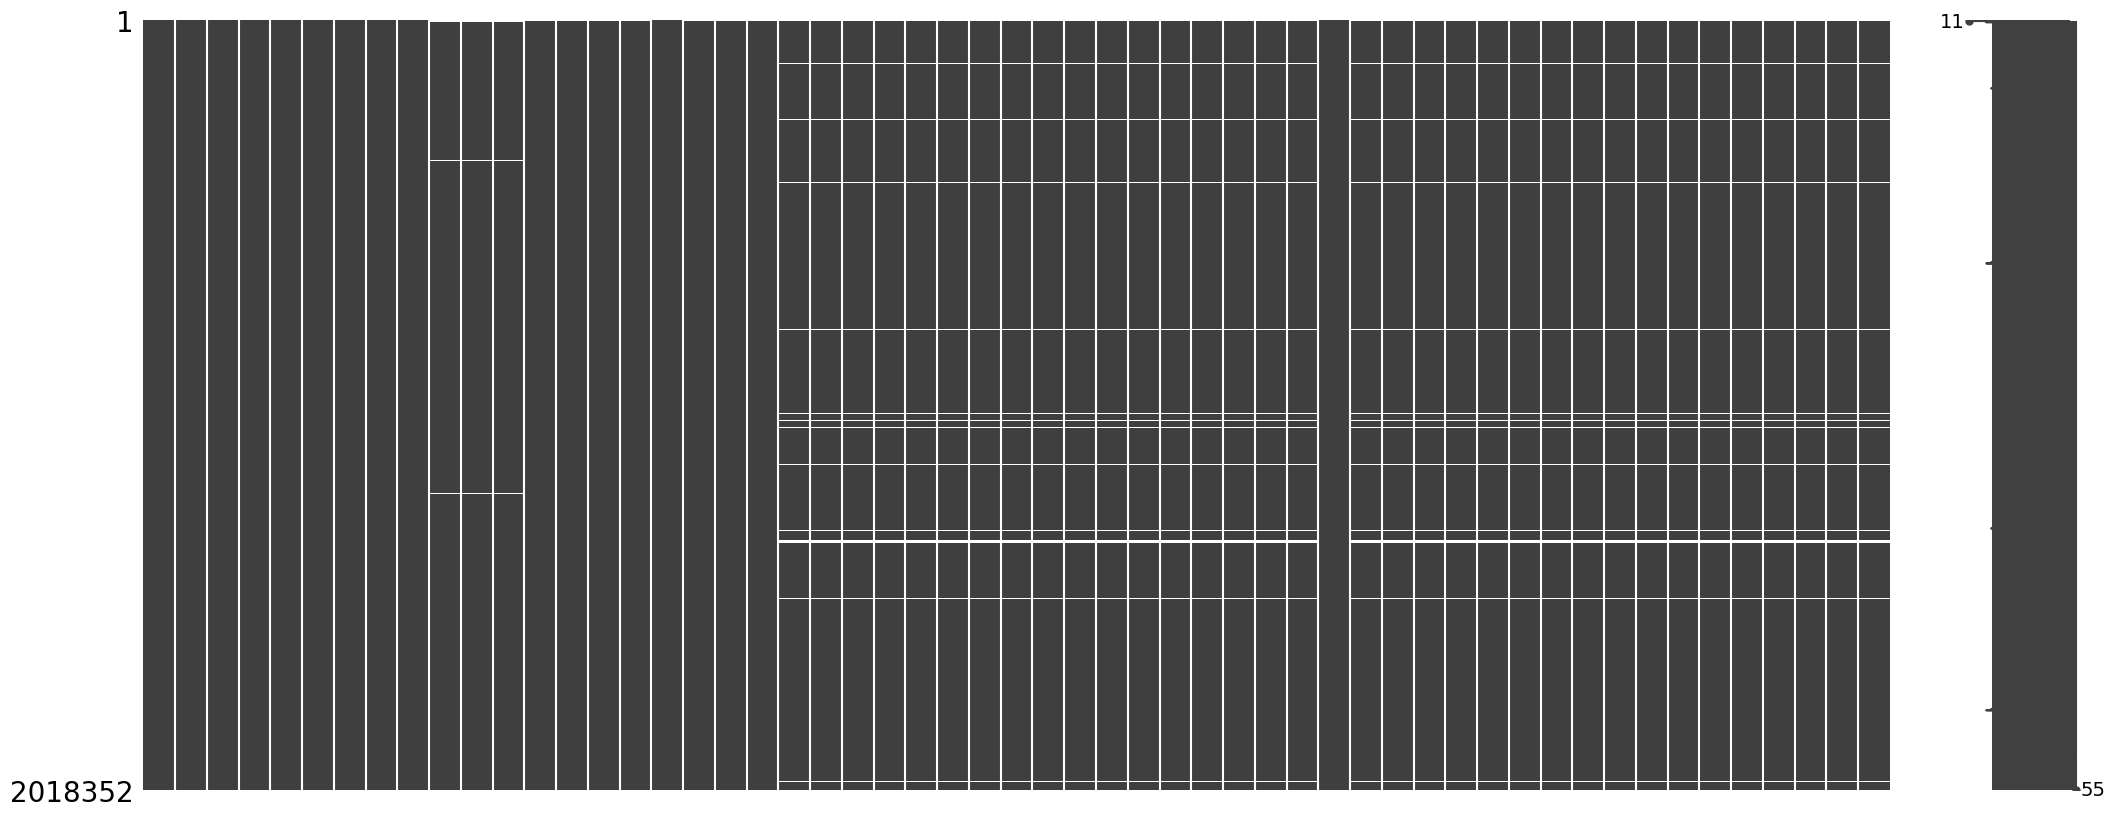

In [89]:
msno.matrix(merged_df)

<Axes: >

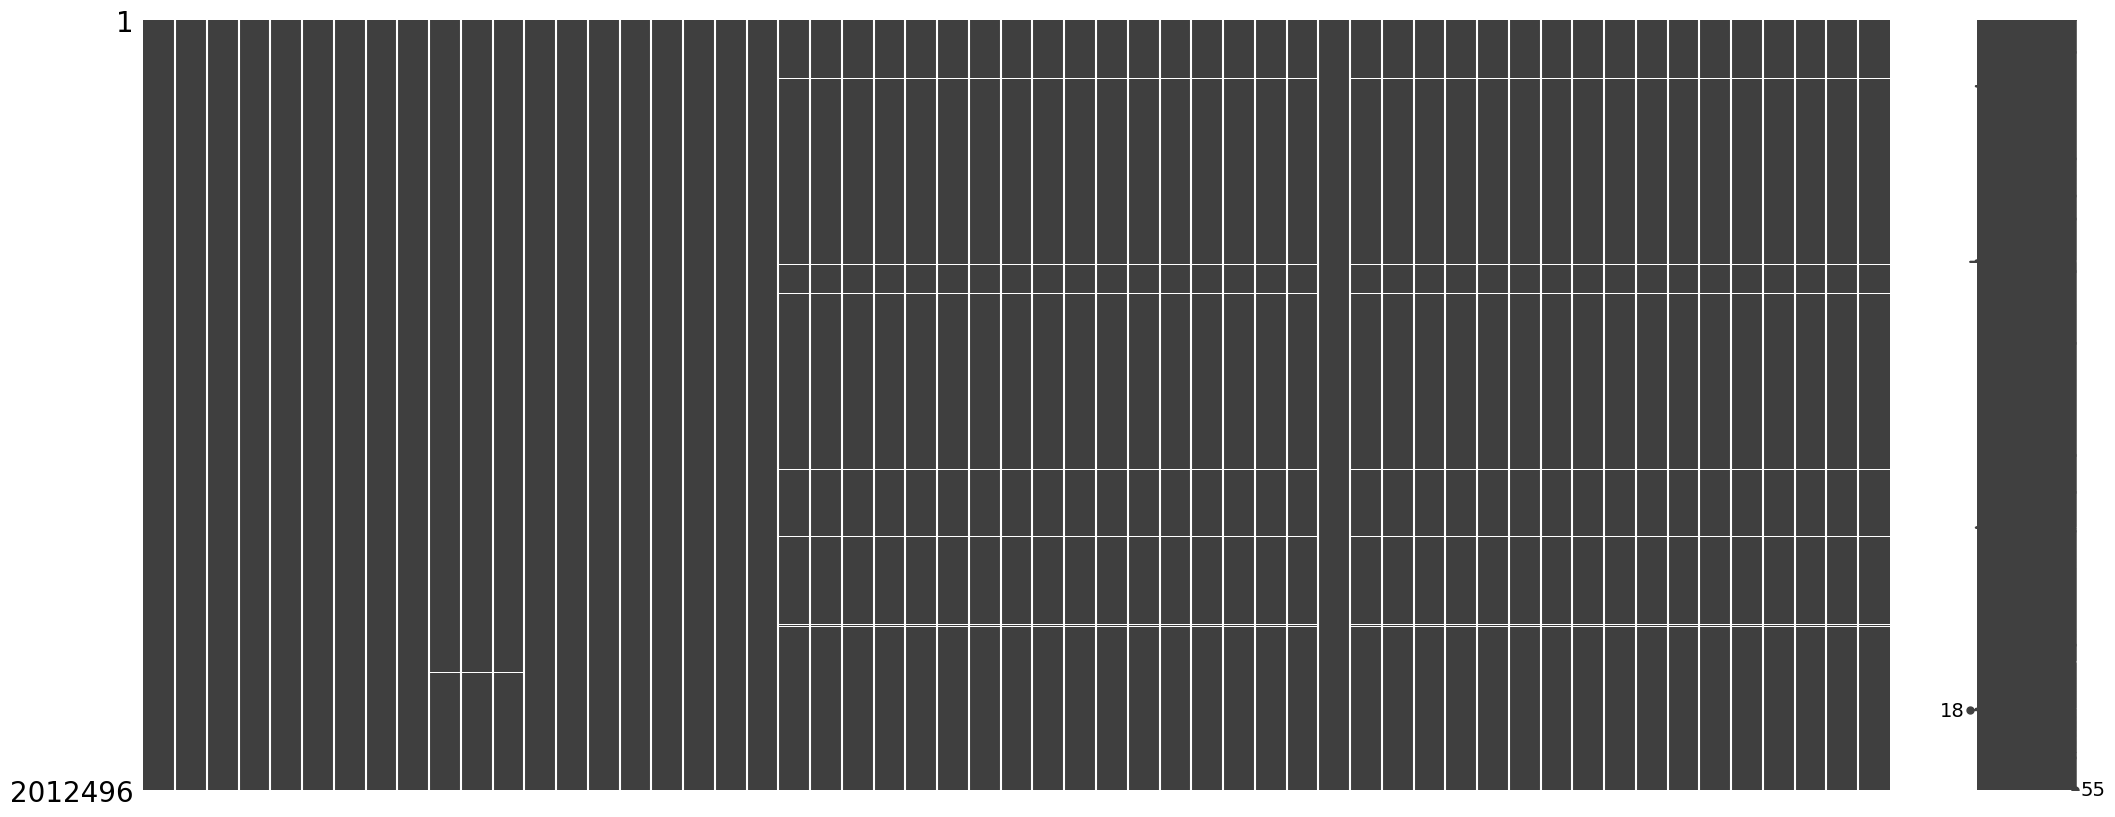

In [90]:
msno.matrix(merged_df.query('data_block_id != 0 and data_block_id != 1'))

<Axes: >

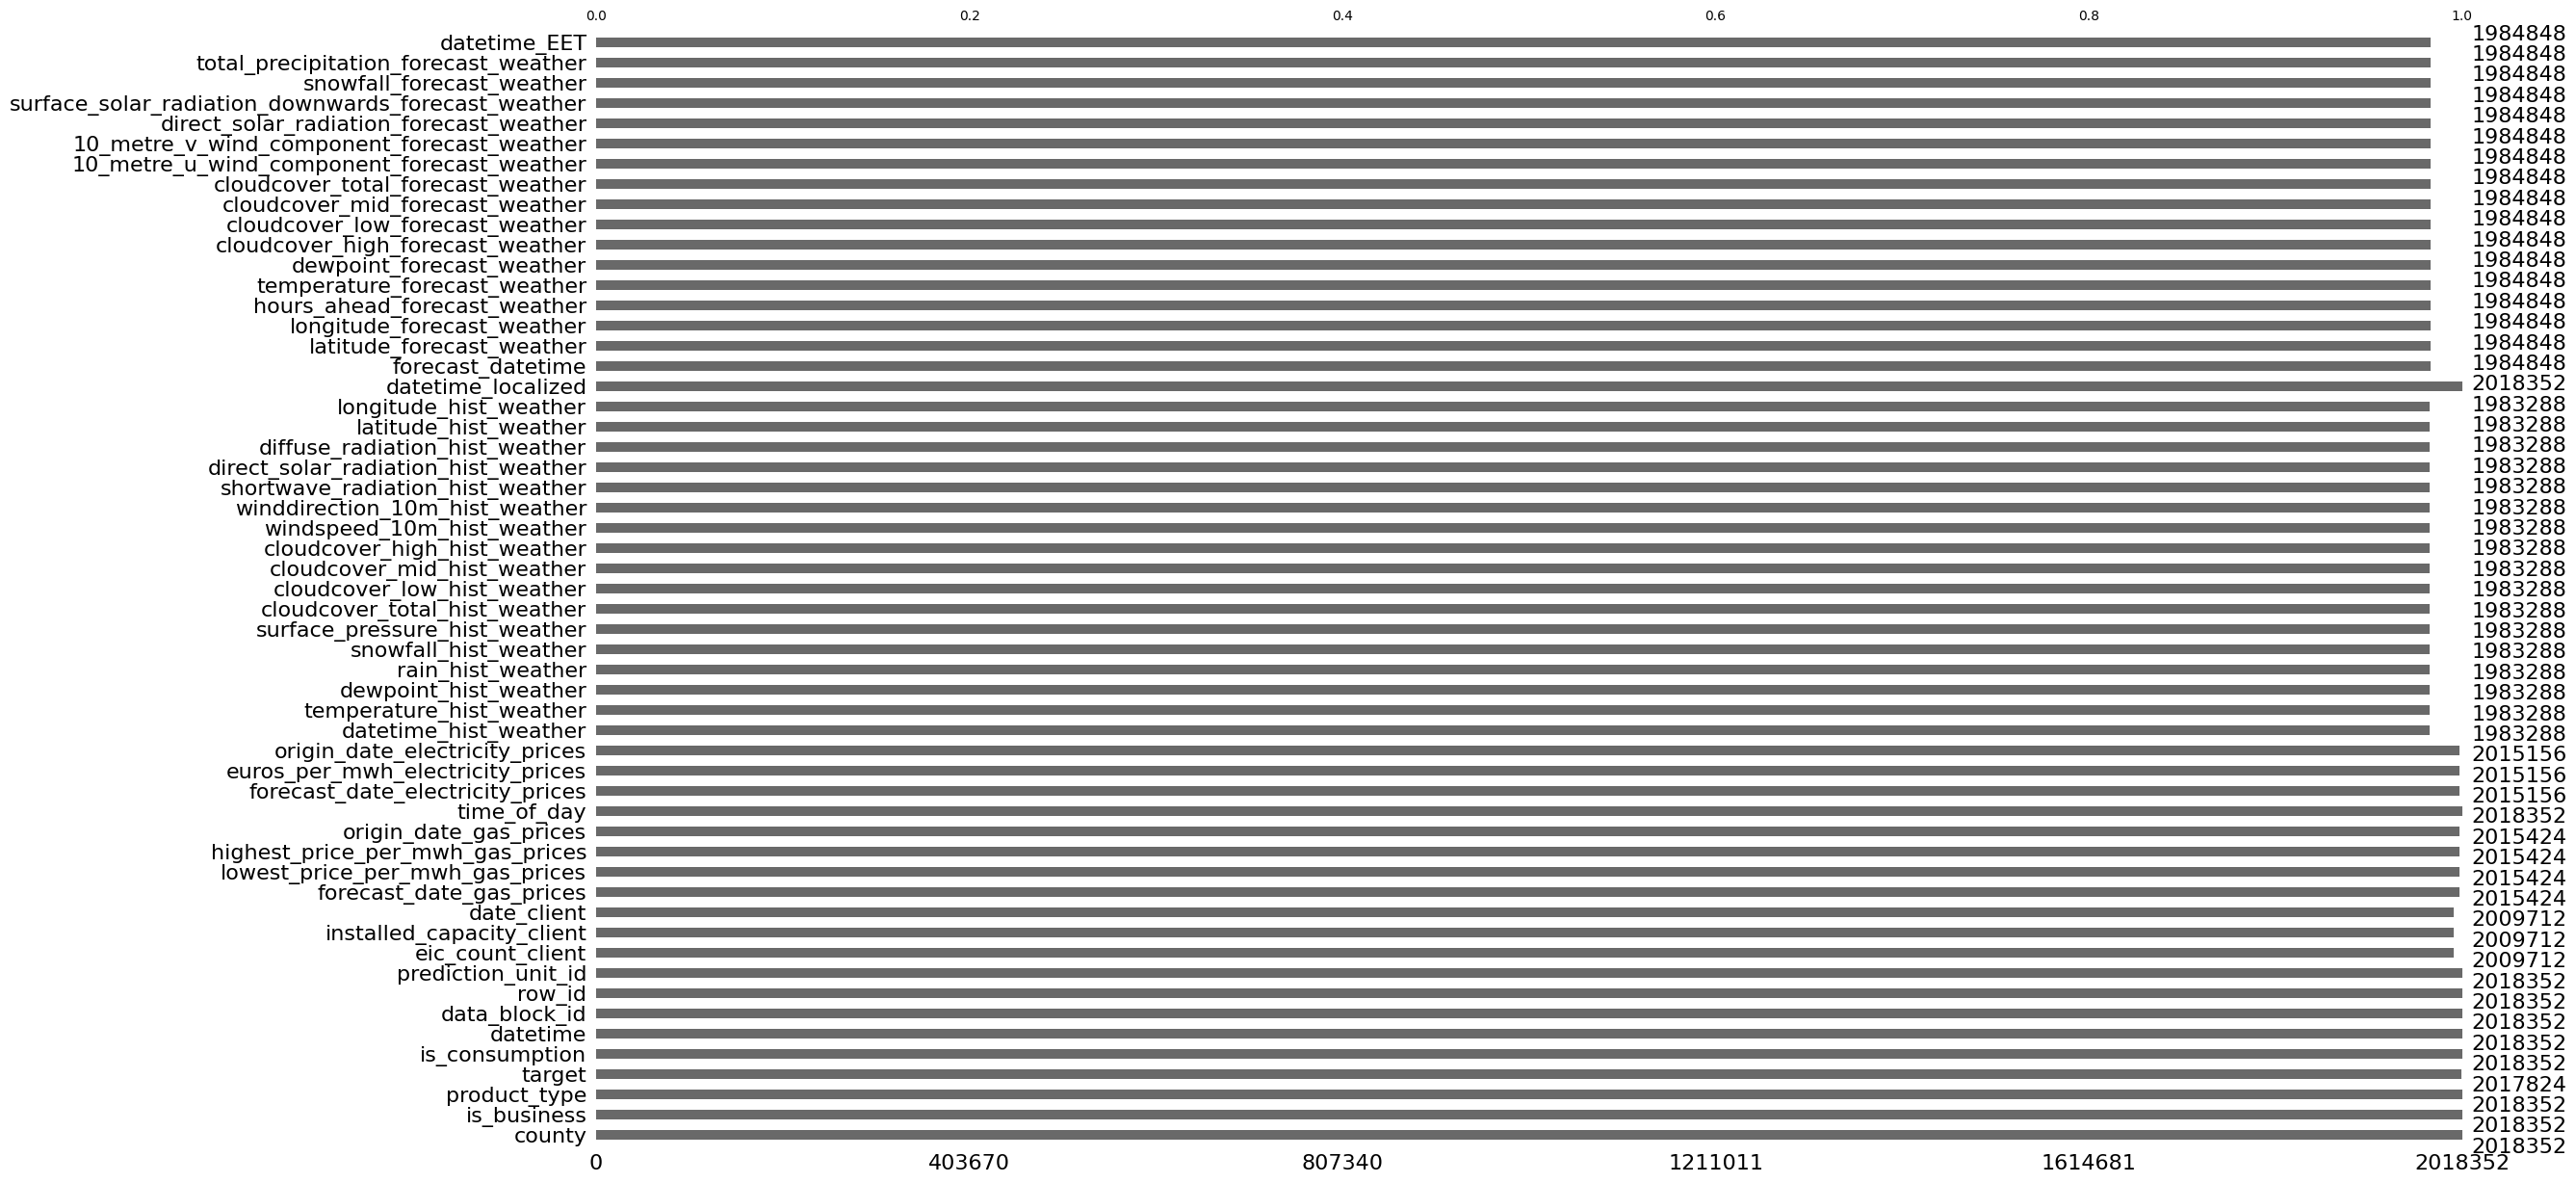

In [91]:
msno.bar(merged_df)

In [92]:
merged_df[(merged_df.temperature_hist_weather.isnull()) & (merged_df.data_block_id == 200)]

# .datetime.dt.date.unique()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,eic_count_client,...,cloudcover_low_forecast_weather,cloudcover_mid_forecast_weather,cloudcover_total_forecast_weather,10_metre_u_wind_component_forecast_weather,10_metre_v_wind_component_forecast_weather,direct_solar_radiation_forecast_weather,surface_solar_radiation_downwards_forecast_weather,snowfall_forecast_weather,total_precipitation_forecast_weather,datetime_EET
612200,12,1,3,1.250,0,2022-03-20 00:00:00,200,612200,49,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
612201,12,1,3,324.651,1,2022-03-20 00:00:00,200,612201,49,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
612332,12,1,3,1.250,0,2022-03-20 01:00:00,200,612332,49,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
612333,12,1,3,324.552,1,2022-03-20 01:00:00,200,612333,49,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
612464,12,1,3,1.200,0,2022-03-20 02:00:00,200,612464,49,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
612465,12,1,3,321.995,1,2022-03-20 02:00:00,200,612465,49,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
612596,12,1,3,1.250,0,2022-03-20 03:00:00,200,612596,49,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
612597,12,1,3,321.500,1,2022-03-20 03:00:00,200,612597,49,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
612728,12,1,3,1.200,0,2022-03-20 04:00:00,200,612728,49,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
612729,12,1,3,321.716,1,2022-03-20 04:00:00,200,612729,49,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [93]:
merged_df.groupby('county').aggregate(lambda x: x.isnull().sum())

,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,eic_count_client,installed_capacity_client,...,cloudcover_low_forecast_weather,cloudcover_mid_forecast_weather,cloudcover_total_forecast_weather,10_metre_u_wind_component_forecast_weather,10_metre_v_wind_component_forecast_weather,direct_solar_radiation_forecast_weather,surface_solar_radiation_downwards_forecast_weather,snowfall_forecast_weather,total_precipitation_forecast_weather,datetime_EET
county,,,,,,,,,,,,,,,,,,,,,
0,0,0,56,0,0,0,0,0,672,672,...,288,288,288,288,288,288,288,288,288,288
1,0,0,24,0,0,0,0,0,288,288,...,144,144,144,144,144,144,144,144,144,144
2,0,0,30,0,0,0,0,0,384,384,...,96,96,96,96,96,96,96,96,96,96
3,0,0,32,0,0,0,0,0,384,384,...,192,192,192,192,192,192,192,192,192,192
4,0,0,38,0,0,0,0,0,480,480,...,192,192,192,192,192,192,192,192,192,192
5,0,0,40,0,0,0,0,0,576,576,...,240,240,240,240,240,240,240,240,240,240
6,0,0,8,0,0,0,0,0,96,96,...,48,48,48,48,48,48,48,48,48,48
7,0,0,46,0,0,0,0,0,1056,1056,...,288,288,288,288,288,288,288,288,288,288
8,0,0,24,0,0,0,0,0,288,288,...,144,144,144,144,144,144,144,144,144,144


In [94]:
train.query('county == 11').shape

(198000, 9)

In [95]:
weather_station_to_county_mapping.query('county == 12')

,county_name,longitude,latitude,county


# EDA

In [96]:
import seaborn as sns

In [97]:
subsampled_df = merged_df.sample(10000)
#sns.scatterplot(data=merged_df, x='datetime', y = 'target', hue='is_consumption')

<Axes: xlabel='datetime', ylabel='target'>

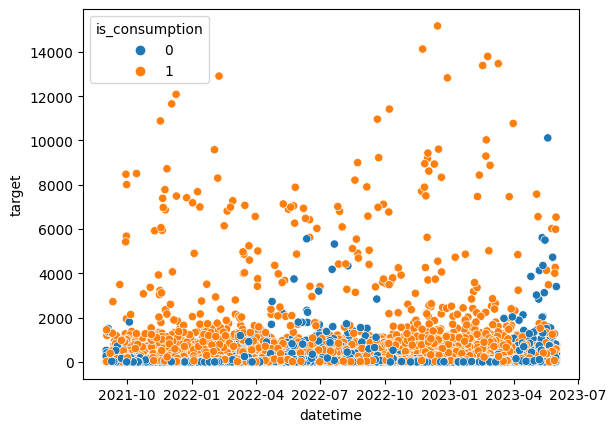

In [98]:
sns.scatterplot(data=subsampled_df, x='datetime', y = 'target', hue='is_consumption')

<Axes: xlabel='target', ylabel='Density'>

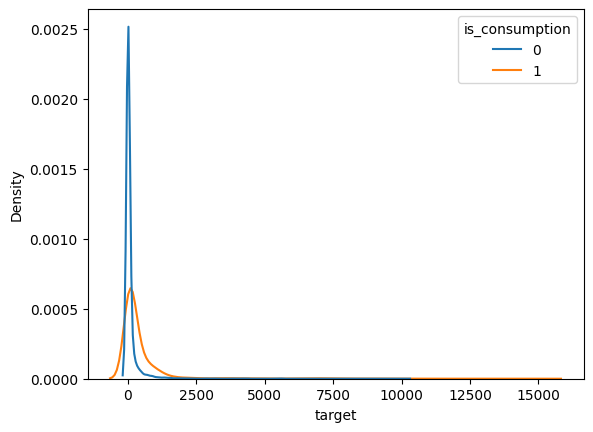

In [99]:
sns.kdeplot(data=subsampled_df, x = 'target', hue='is_consumption')


In [100]:
# subset into production df

production_df = merged_df.query('is_consumption == 0').groupby('datetime').mean(numeric_only=True)

# we should aggregate target by sum, weather variables by  mean

production_df.head()

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id,eic_count_client,installed_capacity_client,...,cloudcover_high_forecast_weather,cloudcover_low_forecast_weather,cloudcover_mid_forecast_weather,cloudcover_total_forecast_weather,10_metre_u_wind_component_forecast_weather,10_metre_v_wind_component_forecast_weather,direct_solar_radiation_forecast_weather,surface_solar_radiation_downwards_forecast_weather,snowfall_forecast_weather,total_precipitation_forecast_weather
datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,7.393443,0.508197,2.0,0.071508,0.0,0.0,60.0,30.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01 01:00:00,7.393443,0.508197,2.0,0.194295,0.0,0.0,182.0,30.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01 02:00:00,7.393443,0.508197,2.0,0.030246,0.0,0.0,304.0,30.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01 03:00:00,7.393443,0.508197,2.0,0.024869,0.0,0.0,426.0,30.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01 04:00:00,7.393443,0.508197,2.0,0.040852,0.0,0.0,548.0,30.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
production_df.size

673728

<Axes: xlabel='cloudcover_total_forecast_weather', ylabel='target'>

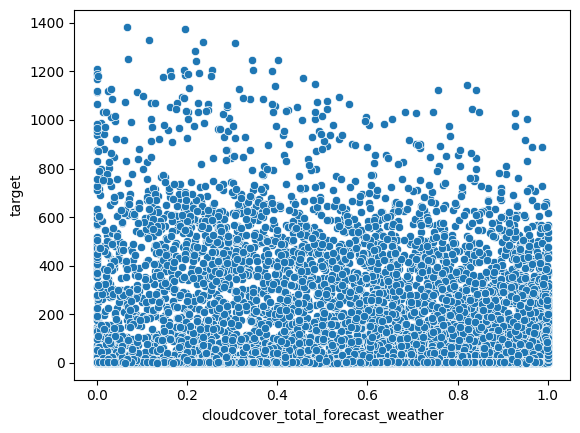

In [102]:
sns.scatterplot(data=production_df, x = 'cloudcover_total_forecast_weather', y = 'target')

<Axes: xlabel='direct_solar_radiation_forecast_weather', ylabel='target'>

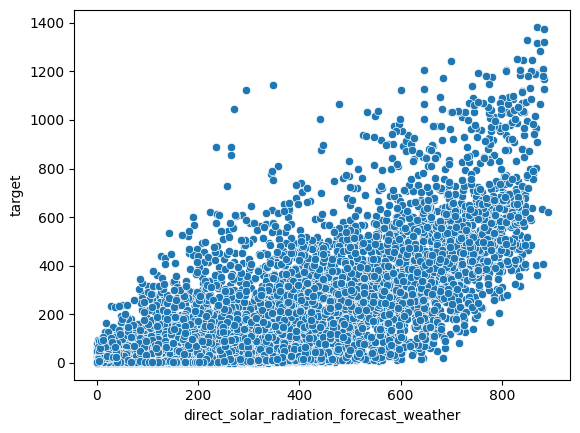

In [103]:
sns.scatterplot(data=production_df, x = 'direct_solar_radiation_forecast_weather', y = 'target')

<Axes: xlabel='surface_solar_radiation_downwards_forecast_weather', ylabel='target'>

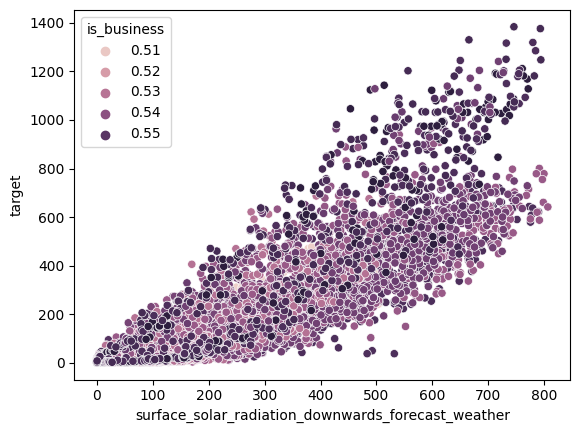

In [104]:
sns.scatterplot(data=production_df, x = 'surface_solar_radiation_downwards_forecast_weather', y = 'target', hue='is_business')

<Axes: xlabel='surface_solar_radiation_downwards_forecast_weather', ylabel='target'>

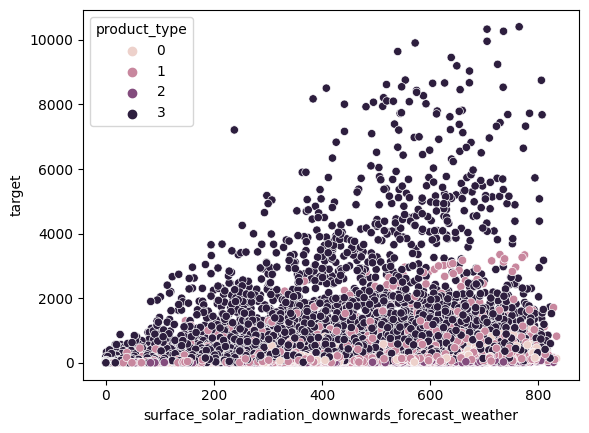

In [105]:
production_df = merged_df.query('is_consumption == 0').sample(100000)
sns.scatterplot(data=production_df, x = 'surface_solar_radiation_downwards_forecast_weather', y = 'target', hue='product_type')

    - Surface solar radiation seems to have a stronger correlation with target than direct_solar
    - There seems to be a 'split' around 6000 (unit?) daily mean target
    - We expected more businesses in the top-producers


In [106]:
client.describe()

,product_type,county,eic_count_client,installed_capacity_client,is_business,date_client,data_block_id
count,41919.000000,41919.000000,41919.000000,41919.000000,41919.000000,41919,41919.000000
mean,1.898996,7.297097,73.345118,1450.771451,0.536773,2022-07-18 21:34:22.921348096,322.898876
min,0.000000,0.000000,5.000000,5.500000,0.000000,2021-09-01 00:00:00,2.000000
25%,1.000000,3.000000,13.000000,321.900000,0.000000,2022-02-13 00:00:00,167.000000
50%,2.000000,7.000000,32.000000,645.200000,1.000000,2022-07-20 00:00:00,324.000000
75%,3.000000,11.000000,70.000000,1567.150000,1.000000,2022-12-23 00:00:00,480.000000
max,3.000000,15.000000,1517.000000,19314.310000,1.000000,2023-05-29 00:00:00,637.000000
std,1.081713,4.780750,144.064389,2422.233120,0.498652,NaN,182.075724


### Focussing only on larger providers (is there a trend visible?)

<Axes: xlabel='surface_solar_radiation_downwards_forecast_weather', ylabel='target'>

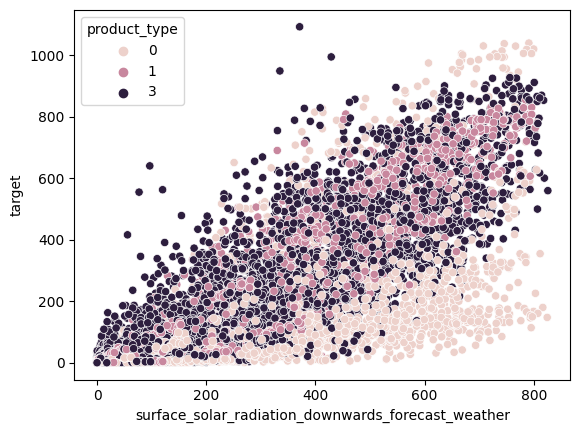

In [107]:
production_df = merged_df.query('(is_consumption == 0) and (1200 < installed_capacity_client < 1300)')
sns.scatterplot(data=production_df, x = 'surface_solar_radiation_downwards_forecast_weather', y = 'target', hue='product_type')


In [108]:
merged_df.query('is_consumption == 0').groupby('product_type')['installed_capacity_client'].aggregate(['min', 'mean', 'max'])

,min,mean,max
product_type,,,
0,260.0,920.328878,4968.600
1,60.0,630.766002,5250.705
2,6.0,88.098622,303.000
3,165.0,2465.757342,19314.310


    - product_type 2 attract producers with small installed capacity thus low production
    - while product_type 3 attract the opposite cluster, producers with a lot of installed_capacity

## Open EDA topics
Check for
- missing values
- dubplicates
- correlations


# Feature engineering

### Add columns for date / time

In [ ]:
def add_features(data):
    # What columns are of type datetime?
    datetime_columns = merged_df.select_dtypes(include='datetime64').columns
    
    for c in datetime_columns:
        print(f"Timezone for {c} is {data[c].dt.tz}")

    # Adding columns for date & time
    data['year']    = data['datetime'].dt.year
    data['quarter'] = data['datetime'].dt.quarter
    data['month']   = data['datetime'].dt.month
    data['week']    = data['datetime'].dt.isocalendar().week
    data['hour']    = data['datetime'].dt.hour 

    data['day_of_year']  = data['datetime'].dt.day_of_year
    data['day_of_month'] = data['datetime'].dt.day
    data['day_of_week']  = data['datetime'].dt.day_of_week

    return data

merged_df = add_features(merged_df)

## -> need to convert to EET timezone

# Scratchbook

In [109]:
px.line(merged_df.query('is_consumption == 1').groupby(['county', 'datetime']).mean(numeric_only=True).reset_index(), x='datetime', y='target', color='county')

NameError: name 'px' is not defined

In [110]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#df = merged_df.query('(is_business not in [1]) and (is_consumption == 0)').groupby(['datetime']).mean(numeric_only=True).reset_index()
aggregations = {'target': 'sum', 'surface_solar_radiation_downwards_forecast_weather': 'mean'}
try:
    df = merged_df.query('(is_business not in [1]) and (is_consumption == 0)').groupby(['datetime']).aggregate(aggregations).reset_index()
except:
    print('mean applied')
    df = merged_df.query('(is_business not in [1]) and (is_consumption == 0)').groupby(['datetime']).aggregate('mean').reset_index()


fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=df['datetime'], y=df['surface_solar_radiation_downwards_forecast_weather'], opacity=0.7),
    secondary_y=True,
    name='solar_radiation'
)

fig.add_trace(
    go.Scatter(x=df['datetime'], y=df['target'], opacity=0.7),
    secondary_y=False,
    name='target'
)

fig

TypeError: Figure.add_trace() got an unexpected keyword argument 'name'

<Axes: xlabel='datetime', ylabel='target'>

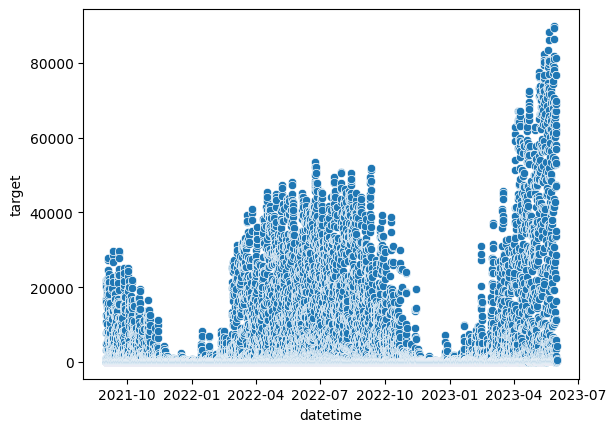

In [111]:
# Production over time
# We look only at the production for every timestamp and sum up the production of every segment on one timestamp

production_timeseries = merged_df.query('is_consumption == 0')[["datetime", "target"]].groupby("datetime").sum()
production_timeseries.reset_index(inplace=True)

# how to get a lineplot??
sns.scatterplot(data=production_timeseries, x="datetime", y="target" )